<p align="center">
  <img src="https://i.ytimg.com/vi/Wm8ftqDZUVk/maxresdefault.jpg" alt="FIUBA" width="25%"/>
  </p>
  
# **Trabajo Práctico 2: Críticas Cinematográficas**
### **Grupo**: 11 - Los Pandas 🐼
### **Cuatrimestre**: 2ºC 2023
### **Corrector**: Mateo Suster
### **Integrantes**:
- ### 106861 - Labollita, Francisco
- ### 102312 - Mundani Vegega, Ezequiel
- ###  97263 - Otegui, Matías Iñaki

# Modelo Random Forest

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

In [15]:
reviews = pd.read_csv('train.csv')

## Implementación del bag of words

In [16]:
vectorizerTotal = CountVectorizer(strip_accents='unicode', dtype='uint16')
vectorizerTotal.fit_transform(reviews['review_es'])

# Primeros 20 elementos
print(vectorizerTotal.get_feature_names_out()[:20])
# Elementos del medio
print(vectorizerTotal.get_feature_names_out()[10000:10020])
# Últimos 20 elementos
print(vectorizerTotal.get_feature_names_out()[-20:])

['00' '000' '00000' '00000000000' '0000000000001' '00000001' '00001'
 '0001' '00015' '000dm' '001' '002' '003830' '006' '0069' '007' '0079'
 '007the' '0080' '0083']
['antisocial' 'antisociales' 'antiste' 'antisunciados' 'antit'
 'antitabaco' 'antitanque' 'antiterroristas' 'antitesis' 'antitetico'
 'antithesis' 'antithetical' 'antitica' 'antitm' 'antitreideros'
 'antitrust' 'antivirus' 'antiwar' 'antm' 'antoina']
['zyuranger' 'zz' 'zzzz' 'zzzzip' 'zzzzz' 'zzzzzzzzz' 'zzzzzzzzzzzzzz'
 'zzzzzzzzzzzzzzzzz' 'zzzzzzzzzzzzzzzzzzzz' 'zzzzzzzzzzzzzzzzzzzzz'
 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'
 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz' 'æbler' 'æon' 'æsthetic'
 'østbye' 'þo' 'þorleifsson' 'יגאל' 'כרמון']


Se ve que varias "palabras" serán números, algunas tendrán símbolos no pertenecientes al alfabeto español y también se comprueba que están palabras españolas.

## Feature engineering del bag of words

En primer lugar, siendo que todas las palabras que inician una oración empiezan en mayúscula, se hará que todas las letras de palabras con una sola mayúscula sean transformadas a minúsculas. De tal manera que en el siguiente ejemplo, las dos variaciones de hermosa sean una misma palabra: "Hermosa película" y "Esta película es hermosa".

In [17]:
matrizApariciones = vectorizerTotal.fit_transform(reviews['review_es'])

In [18]:
matrizSiAparece = matrizApariciones.toarray()
matrizApariciones = matrizApariciones.toarray()

In [19]:
matrizSiAparece[matrizSiAparece > 0] = 1

In [20]:
words_df = pd.DataFrame()
words_df['Palabra'] = vectorizerTotal.get_feature_names_out()
words_df['Apariciones Totales'] = matrizApariciones.sum(axis=0).tolist() #Cuántas veces aparece la palabra
words_df['Apariciones'] = matrizSiAparece.sum(axis=0).tolist()           #En cuántas reviews aparece la palabra

In [21]:
#Se cuentan en cuántas reviews positivas aparece cada palabra
listaAparicionesPositivas = np.zeros(shape=len(matrizSiAparece[0])).astype('int32')
for i in range(reviews.shape[0]):
    if (reviews.iloc[i]['sentimiento'] == 'positivo'):
        listaAparicionesPositivas += matrizSiAparece[i]

#Se cuentan en cuántas reviews negativas aparece cada palabra
listaAparicionesNegativas = np.zeros(shape=len(matrizSiAparece[0])).astype('int32')
for i in range(reviews.shape[0]):
    if (reviews.iloc[i]['sentimiento'] == 'negativo'):
        listaAparicionesNegativas += matrizSiAparece[i]

In [22]:
words_df['Apariciones positivas'] = listaAparicionesPositivas
words_df['Apariciones negativas'] = listaAparicionesNegativas
words_df['Fracción apariciones positivas'] = words_df['Apariciones positivas'] / words_df['Apariciones']
words_df['Fracción apariciones negativas'] = words_df['Apariciones negativas'] / words_df['Apariciones']
words_df['Tasa de positividad'] = (words_df['Apariciones positivas'] - words_df['Apariciones negativas']) / words_df['Apariciones']
words_df.sort_values(by='Apariciones', inplace=True, ascending=False)
words_df.head(10)

,Palabra,Apariciones Totales,Apariciones,Apariciones positivas,Apariciones negativas,Fracción apariciones positivas,Fracción apariciones negativas,Tasa de positividad
41364,de,661907,47992,23949,24043,0.499021,0.500979,-0.001959
128119,que,395365,47245,23501,23744,0.497428,0.502572,-0.005143
93125,la,405160,47147,23496,23651,0.498356,0.501644,-0.003288
55382,en,276429,45938,22882,23056,0.498106,0.501894,-0.003788
53511,el,253915,45037,22381,22656,0.496947,0.503053,-0.006106
162711,una,170883,43530,21815,21715,0.501149,0.498851,0.002297
58627,es,183244,43210,21708,21502,0.502384,0.497616,0.004767
162707,un,186195,43041,21390,21651,0.496968,0.503032,-0.006064
111087,no,145805,42253,19918,22335,0.471398,0.528602,-0.057203
60252,esta,119728,40952,20067,20885,0.490013,0.509987,-0.019975


### Se entrena un módelo posible de Random Forest

In [23]:
x_train, x_test, y_train, y_test = train_test_split(reviews['review_es'], reviews['sentimiento'], test_size=0.3, random_state=2)

In [24]:
vectorizer = CountVectorizer()
x_train_counts = vectorizer.fit_transform(x_train)

model = RandomForestClassifier(max_features='sqrt',
                             random_state=2,
                             n_jobs=-1,
                             criterion="entropy",
                             n_estimators=50)

model.fit(x_train_counts, y_train)

x_test_counts = vectorizer.transform(x_test)
y_test_pred = model.predict(x_test_counts)

Matriz de confusión de los datos de prueba


Text(50.722222222222214, 0.5, 'True')

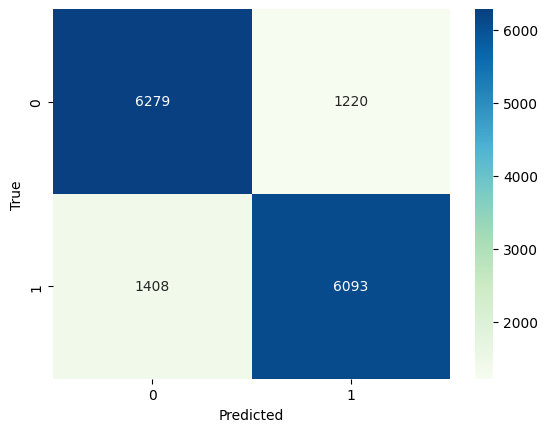

In [25]:
tabla = confusion_matrix(y_test, y_test_pred)
print("Matriz de confusión de los datos de prueba")
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [26]:
accuracy = accuracy_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred, pos_label='positivo')
precision = precision_score(y_test, y_test_pred, pos_label='positivo')
f1 = f1_score(y_test, y_test_pred, pos_label='positivo')

print("Cálculo de las métricas en el conjunto de pruebas")
print("Accuracy: "+str(round(accuracy, 3)))
print("Recall: "+str(round(recall,3)))
print("Precision: "+str(round(precision,3)))
print("F1 Score: "+str(round(f1,3)))

Cálculo de las métricas en el conjunto de pruebas
Accuracy: 0.825
Recall: 0.812
Precision: 0.833
F1 Score: 0.823


## Se buscan los hiperparámetros con GridSearch CV

Se realizó una busqueda de los mejores parámetros con el método GridSearchCV proporcionando varios parámetros posibles basados en lo estudiado en las clases prácticas.

Se obtuvo que los mejores hiperparámetros (utilizando el F1 score como métrica) para este caso son:

- *min_samples_leaf* = $1$
- Criterio = entropy
- *min_samples_split* = 12
- *n_estimators* = 300

Logrando un F1 score de 0.855, mayor en comparación al primer árbol obtenido que fue de 0.823

In [27]:
x_train, x_test, y_train, y_test = train_test_split(reviews['review_es'], reviews['sentimiento'], test_size=0.3, random_state=0)

In [29]:
model = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', RandomForestClassifier(max_features='sqrt',
     oob_score=True, random_state=1, n_jobs=-1))
])

params_grid = {
    "clf__criterion": ["gini", "entropy"],
    "clf__min_samples_leaf": [1, 5, 10],
    "clf__min_samples_split": [2, 4, 10, 12, 16],
    "clf__n_estimators": [50, 100, 200, 300]
}

scorer_fn = make_scorer(f1_score, pos_label='positivo')
kfoldcv = StratifiedKFold(n_splits=5)

gridcv = GridSearchCV(estimator=model,
                      param_grid=params_grid,
                      scoring=scorer_fn,
                      cv=kfoldcv
                      )

model = gridcv.fit(x_train, y_train)

y_pred = model.predict(x_test)
score = f1_score(y_test, y_pred, pos_label='positivo')
print("Parámetros:", gridcv.best_params_, "\nF1 score: ", round(score, 3))

Parámetros: {'clf__criterion': 'entropy', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 12, 'clf__n_estimators': 300} 
F1 score:  0.855


In [30]:
model = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', RandomForestClassifier(max_features='sqrt',
                                   oob_score=True,
                                   random_state=1,
                                   n_jobs=-1,
                                   criterion='entropy',
                                   min_samples_leaf=1,
                                   min_samples_split=12,
                                   n_estimators=300))
])


model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)

Matriz de confusión de los datos de prueba


Text(50.722222222222214, 0.5, 'True')

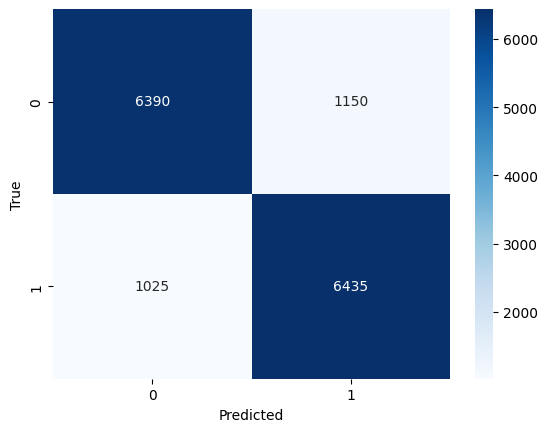

In [31]:
print("Matriz de confusión de los datos de prueba")
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [32]:
accuracy = accuracy_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred, pos_label='positivo')
precision = precision_score(y_test, y_test_pred, pos_label='positivo')
f1 = f1_score(y_test, y_test_pred, pos_label='positivo')

print("Cálculo de las métricas en el conjunto de pruebas")
print("Accuracy: "+str(round(accuracy, 3)))
print("Recall: "+str(round(recall, 3)))
print("Precision: "+str(round(precision, 3)))
print("F1 Score: "+str(round(f1, 3)))

Cálculo de las métricas en el conjunto de pruebas
Accuracy: 0.855
Recall: 0.863
Precision: 0.848
F1 Score: 0.855


## Predicción del conjunto test

In [35]:
test_df = pd.read_csv('test.csv')

y_pred_test = model.predict(test_df['review_es'])

test_df['sentimiento'] = y_pred_test

test_df.drop("review_es", axis=1, inplace=True)
test_df.to_csv('sample_solution.csv', index=False)